# **How trustworthy is your local representative?**

#### Data Sources:
politifact api documentation: http://static.politifact.com/api/v2apidoc.html <br>
govtrack api documentation: https://www.govtrack.us/developers/api <br>
propublica: https://projects.propublica.org/api-docs/congress-api/ <br>
congressional misconduct database: https://www.govtrack.us/misconduct <br>
news api: https://newsapi.org/docs <br>
votesmart: https://github.com/votesmart/python-votesmart/tree/master

## To do: April 15

1. Scrape truth-o-meter data ✅
2. Join truth-o-meter, misconduct db, and propublica ✅
3. Structure bills & votes **(in-progress)**
4. Incorporate news headlines
5. incorprate tweets (?)


In [1]:
# install Propublica congress api client module (from https://github.com/eyeseast/propublica-congress)
# ! pip3 install python-congress # <= uncomment this here

In [6]:
import requests

import json

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt

from congress import Congress
propublica_key = 'wAxQ7sF8gcXCBRnY3lzegT23aljM4saALOb6JPlR'
congress = Congress(propublica_key)

from IPython.display import clear_output, display

import os
import time
import ast

import requests
from lxml import html

% matplotlib inline

In [8]:
password = 'dwdstudent2015'
password = input('SQL Password (Remove if on Amazon Server):')
clear_output()

In [3]:
def open_json(file_name,folder='/data'):
    
    '''Read json'''
    
    if file_name[0] != '/':
        file_name = '/'+file_name
    if '.json' not in file_name:
        file_name = file_name+'.json'

    cwd = os.getcwd()

    if folder not in file_name:
        if cwd not in file_name:
            file_path = cwd+folder+file_name
        else:
            file_path = folder + file_name
    elif cwd not in file_name:
        file_path = cwd+file_name
    else:
        file_path = file_name
    file_path
    
    file = open(file_path,'r')
    res = json.load(file,)
    file.close()
    return res

## Get Politifact Data
politifact api documentation: http://static.politifact.com/api/v2apidoc.html  <br>
Markdown for `get_politifact.py` script below

```python    
import requests
import json
import os
import time
from IPython.display import clear_output  # Remove in script

t0 = time.time()
t1 = t0

def get_politifact(limit,offset):
    """Scrape Politifact API"""
    pf_url = 'http://www.politifact.com/api/v/2/statement/'
    params = {
        'format' : 'json',
        'edition__edition_slug':'truth-o-meter',
        'limit' : limit,
        'offset' : offset,
        'order_by' : 'ruling_date'}
    resp = requests.get(pf_url,params=params).json()
    res = resp['objects']
    return res

folder = '/data'
file_name = '/politifact_test.json'
cwd = os.getcwd()
file_path = cwd+folder+file_name

if not os.path.isdir(cwd+folder):
    os.mkdir(cwd+folder)
    print('* New dir made: ',cwd+folder)
    
if not os.path.isfile(file_path):
    politifact_list = list()
    print('* New file made:',file_path)
    offset = 0
else:
    file = open(file_path,'r')
    politifact_list = json.load(file)
    file.close()
    offset = len(politifact_list) + 1

duplicate = 0
limit = 30
n = 0
nr = 0

print('#'*5, 'Scrape Politifact Script','#'*5)
print('Round:',nr)
print('List len:',len(politifact_list))
print('Duplicates:',duplicate)
print('Batch size:',limit)
print('*'*20)

while True:
    try:
        print('Iteration:',n)
        print('Start:',offset)

        batch = get_politifact(limit,offset) # api fetch

        if len(batch) == 0:
            print('#'*5,'Complete','#'*5)
            print(file_path)
            break

        for entry in batch:
            if entry in politifact_list:
                duplicate += 1
            elif entry not in politifact_list:
                politifact_list.append(entry)
        print('list len:',len(politifact_list))
        print('='*3)

        file = open(file_path, 'w')
        json.dump(politifact_list, file, ensure_ascii=False)
        file.close()
                        
        n+=1
        offset += limit
        if n % 5 == 0:
            timer0 = time.time()-t0
            timer1 = time.time()-t1
            t1 = time.time()

            os.system('clear')
            clear_output() # Remove in script
            print('#'*5, 'Scrape Politifact Script','#'*5)
            print('Round:',nr)
            print('Duplicates:',duplicate)
            print('Batch size:',limit)
            print('Round run time:',int(timer1/60),'m',round(timer1%60,2),'s')
            print('Total run time:',int(timer0/60),'m',round(timer0%60,2),'s')
            print('*'*20)
            nr += 1
    except:
        print('#'*5,'STOPPED','#'*5)
        print(file_path)
        break
file = open(file_path, 'w')
json.dump(politifact_list, file, ensure_ascii=False)
file.close()
```

## Cleaning Politifact

In [4]:
def clean_politifact(pf):
    
    '''Clean politifact data from politifact raw json'''
    
    if type(pf) != pd.core.frame.DataFrame:
        pf = pd.DataFrame(pf)
    
    pf.sort_values('statement_date',ascending=False,inplace=True)
    pf.reset_index(inplace=True)

    pf['statement_date'] = pd.to_datetime(pf['statement_date'])
    pf['ruling_date'] = pd.to_datetime(pf['ruling_date'])
    pf['statement'] = (pf['statement'].str.replace('<p>',"").str.replace('</p>','')
                       .str.replace('"','').str.replace('&quot;','')
                       .str.replace('\r','').str.replace('\n','').str.replace('&#39;','\''))
    pf['ruling_comments'] = (pf['ruling_comments'].str.replace('<p>',"").str.replace('</p>','')
                       .str.replace('"','').str.replace('&quot;','')
                       .str.replace('\r','').str.replace('\n','').str.replace('&#39;','\''))

    pf['ruling_slug'] = [ruling['ruling_slug'] for ruling in pf['ruling']]

    pf['name_slug'] = [speaker['name_slug'] for speaker in pf['speaker']]
    pf['home_state'] = [speaker['home_state'] for speaker in pf['speaker']]
    pf['party'] = [speaker['party']['party_slug'] for speaker in pf['speaker']]
    pf['first_name'] = [speaker['first_name'] for speaker in pf['speaker']]
    pf['last_name'] = [speaker['last_name'] for speaker in pf['speaker']]

    pf['statement_type'] = [statement['statement_type'] for statement in pf['statement_type']]

    pf['subject_slug'] = [[subject['subject_slug'] for subject in subjects] for subjects in pf['subject']]
    
    pf = pf[['ruling_slug','first_name','last_name','name_slug',
                 'home_state','party','statement',
                 'subject_slug','ruling_comments','ruling_date',
                 'statement_context','statement_type','statement_date',
                 'twitter_headline','sources']]
    return pf

In [5]:
    # upload to pandas this way to prevent memory error
politifact = clean_politifact(open_json('politifact.json'))

In [6]:
len(politifact)

4825

# Govtrack (Deprecated)
govtrack api documentation: https://www.govtrack.us/developers/api <br>
still useful sometimes

In [7]:
# Data on legislators

person = 'https://www.govtrack.us/api/v2/person'
role = 'https://www.govtrack.us/api/v2/role'

params = {
    'current' : 'true'
}

resp = requests.get(person).json()

legis = pd.DataFrame(resp['objects'])
hillary = legis[legis['lastname']=='Clinton']['bioguideid'].iloc[0]

# Propublica
propublica: https://projects.propublica.org/api-docs/congress-api/  <br>
api client github: https://github.com/eyeseast/propublica-congress

In [8]:
# activate to install propublica congress library
# ! pip3 install python-congress

### 1. Congress Members

In [9]:
congress_meeting = 102 # Earliest congress is 80 for senate, 102 for house
congress_meeting = 115 # Latest is 115

def get_congress(congress_meeting=115):
    
    global bio_col,position_col,policy_col,other_col,congress_cols

    bio_col = ['first_name','last_name','middle_name','date_of_birth','id']
    position_col = ['title','party','seniority', # Seniority = years served
                     'state','district','state_rank','leadership_role',
                    'in_office','next_election']
    policy_col = ['dw_nominate','votes_with_party_pct','missed_votes_pct','missed_votes']
    other_col = ['chamber','gender','congress','twitter_account']

    congress_cols = bio_col+position_col+policy_col+other_col
    
    if congress_meeting >= 80: # Oldest Senate meeting on file
        sen = congress.members.filter('senate',congress = congress_meeting)
        for member in sen[0]['members']:
            member['congress'] = int(congress_meeting)
            member['district'] = np.nan
            member['chamber'] = 'Senate'
            for col in congress_cols:
                if col not in member.keys():
                    member[col] = np.nan
        senate = pd.DataFrame(sen[0]['members'])[congress_cols]
    else:
        senate = None
        
    if congress_meeting >= 102: # Oldest House meeting on file
        rep = congress.members.filter('house', congress = congress_meeting)
        for member in rep[0]['members']:
            member['congress'] = int(congress_meeting)
            member['state_rank'] = np.nan
            member['chamber'] = 'House'
            for col in congress_cols:
                if col not in member.keys():
                    member[col] = np.nan
        house = pd.DataFrame(rep[0]['members'])[congress_cols]
    else:
        house = None
    
    return senate, house

In [10]:
senate,house = get_congress()

In [11]:
pd.DataFrame(columns=congress_cols,index=[])

,first_name,last_name,middle_name,date_of_birth,id,title,party,seniority,state,district,...,in_office,next_election,dw_nominate,votes_with_party_pct,missed_votes_pct,missed_votes,chamber,gender,congress,twitter_account


In [12]:
all_senate = pd.DataFrame(columns=congress_cols)
all_house = pd.DataFrame(columns=congress_cols)

for meet in range(80,116):
    senate,house = get_congress(meet)
    
    all_senate = all_senate.append(senate).reset_index()[congress_cols]
    all_house = all_house.append(house).reset_index()[congress_cols]
    
    display(all_senate.tail(1).append(all_house.tail(1))[other_col+bio_col])

,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
101,Senate,M,80,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
210,Senate,M,81,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
315,Senate,M,82,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
429,Senate,M,83,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
532,Senate,M,84,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
634,Senate,M,85,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
740,Senate,M,86,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
850,Senate,M,87,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
958,Senate,M,88,None,Stephen,Young,Marvin,1889-05-04,Y000053


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1063,Senate,M,89,None,Stephen,Young,Marvin,1889-05-04,Y000053


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1167,Senate,M,90,None,Stephen,Young,Marvin,1889-05-04,Y000053


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1271,Senate,M,91,None,Stephen,Young,Marvin,1889-05-04,Y000053


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1376,Senate,M,92,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1483,Senate,M,93,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1591,Senate,M,94,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1703,Senate,M,95,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1806,Senate,M,96,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1907,Senate,M,97,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2009,Senate,M,98,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2111,Senate,M,99,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2212,Senate,M,100,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2313,Senate,M,101,None,Timothy,Wirth,E.,1939-09-22,W000647


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2417,Senate,M,102,None,Harris,Wofford,None,1926-04-09,W000665
447,House,M,102,None,Richard,Zimmer,None,1944-08-16,Z000008


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2522,Senate,M,103,None,Harris,Wofford,None,1926-04-09,W000665
895,House,M,103,None,Richard,Zimmer,None,1944-08-16,Z000008


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2626,Senate,M,104,RonWyden,Ron,Wyden,None,1949-05-03,W000779
1347,House,M,104,None,Richard,Zimmer,None,1944-08-16,Z000008


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2726,Senate,M,105,RonWyden,Ron,Wyden,None,1949-05-03,W000779
1797,House,M,105,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2828,Senate,M,106,RonWyden,Ron,Wyden,None,1949-05-03,W000779
2242,House,M,106,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2933,Senate,M,107,RonWyden,Ron,Wyden,None,1949-05-03,W000779
2690,House,M,107,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
3033,Senate,M,108,RonWyden,Ron,Wyden,None,1949-05-03,W000779
3136,House,M,108,None,C. W. Bill,Young,None,1930-12-16,Y000031


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
3134,Senate,M,109,RonWyden,Ron,Wyden,None,1949-05-03,W000779
3582,House,M,109,None,C. W. Bill,Young,None,1930-12-16,Y000031


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
3236,Senate,M,110,RonWyden,Ron,Wyden,None,1949-05-03,W000779
4035,House,M,110,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
3347,Senate,M,111,RonWyden,Ron,Wyden,None,1949-05-03,W000779
4487,House,M,111,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
3449,Senate,M,112,RonWyden,Ron,Wyden,None,1949-05-03,W000779
4938,House,M,112,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
3554,Senate,M,113,RonWyden,Ron,Wyden,None,1949-05-03,W000779
5388,House,M,113,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
3654,Senate,M,114,RonWyden,Ron,Wyden,None,1949-05-03,W000779
5836,House,M,114,RepRyanZinke,Ryan,Zinke,None,1961-11-01,Z000018


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
3758,Senate,M,115,RepToddYoung,Todd,Young,None,1972-08-24,Y000064
6284,House,M,115,RepRyanZinke,Ryan,Zinke,None,1961-11-01,Z000018


In [13]:
senate_members = all_senate.drop_duplicates('id',keep='last').reset_index()[congress_cols]
house_members = all_house.drop_duplicates('id',keep='last').reset_index()[congress_cols]

print('Members in every senate & house:',len(all_senate),'|',len(all_house))
print('Unique members in senate & house:',len(senate_members),'|',len(house_members))

Members in every senate & house: 3759 | 6285
Unique members in senate & house: 598 | 1365


### Creating Foreign Key for Propublica and Politifact

In [14]:
def add_name_slug(members,politifact=politifact,show=False):
    '''Connecting members to Politifact with name_slug'''
    # add preliminary name_slug from first name and last name
    members['name_slug'] = members['first_name'].str.lower() + '-' + members['last_name'].str.lower()
    not_in = members[~members['name_slug'].isin(politifact['name_slug'])] # filters slugs not in politifact (pf)
    slug_filter = not_in[not_in['last_name'].isin(politifact['last_name'])] # filters above w/ last name in pf

    name = ['first_name','last_name']
    col = 'last_name'
    
    new_slugs = list()
    for i in range(len(slug_filter)):
        
        matching = slug_filter[col].iloc[i]
        # Get matches with same last_name
        result = politifact[politifact[col] == matching]

        n = 2 # Get matches with first 2 letters of first name
        result = result[result['first_name'].str[:n] == slug_filter['first_name'].str[:n].iloc[i]]

        if len(result) > 0: # Add name_slug from politifcact if matches found
            slug = result['name_slug'].iloc[0]
            new_slugs.append(slug)
        else: # If no matches, keep old slug
            slug = slug_filter['name_slug'].iloc[i]
            new_slugs.append(slug)
            
    # Change slugs in filter to new_slugs list
    slug_filter.loc[:,'name_slug'] = new_slugs
    
    senate_exceptions = ['john-kennedy','david-boren','john-walsh']
    house_exceptions = ['john-miller','lawrence-smith','don-edwards','katherine-harris']
    exceptions = senate_exceptions+house_exceptions
    
    # Change slugs in original DataFrame
    old, new, bioguide = [],[],[]
    for index in slug_filter.index: # index is still the same from original dataframe
        # condition: slug in original is different from filter
        if not members.loc[index]['name_slug'] == slug_filter.loc[index]['name_slug']:
            if members.loc[index]['name_slug'] in exceptions: # exception found manually
                pass
            else:
                bioguide.append(members.loc[index]['id'])
                old.append(members.loc[index]['name_slug'])
                members.loc[index,'name_slug'] = slug_filter.loc[index]['name_slug']
                new.append(members.loc[index]['name_slug'])
    if show == True: # Show results in a dataframe
        display(pd.DataFrame({'old':old,'new':new,'id':bioguide})[['id','old','new']])
    return members

In [15]:
senate = add_name_slug(all_senate)
house = add_name_slug(all_house)

print('Senate:')
dummy = add_name_slug(senate_members,show=True) # Show results with unique members
print('House:')
dummy = add_name_slug(house_members,show=True)

/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Senate:


,id,old,new
0,G000353,frank-graham,franklin-graham
1,J000127,edwin-johnson,eddie-bernice-johnson
2,G000320,albert-gore,al-gore
3,G000321,albert-gore,al-gore
4,S000059,richard-santorum,rick-santorum
5,B000444,joseph-biden,joe-biden
6,D000388,christopher-dodd,chris-dodd
7,L000304,joseph-lieberman,joe-lieberman
8,C000542,daniel-coats,dan-coats
9,C001047,shelley-capito,shelley-moore-capito


House:


,id,old,new
0,H000388,charles-hayes,chris-hayes
1,S000059,richard-santorum,rick-santorum
2,K000110,joseph-kennedy,joe-kennedy
3,T000461,patrick-toomey,pat-toomey
4,C000141,benjamin-cardin,ben-cardin
5,C000830,christopher-cox,chris-cox
6,S000033,bernard-sanders,bernie-s
7,L000552,ray-lahood,raymond-lahood
8,H000676,peter-hoekstra,pete-koekstra
9,B001276,ann marie-buerkle,ann-marie-buerkle


In [16]:
# upload to json file
folder = '/data'
path = os.getcwd()+folder
senate.to_json(path + '/senate.json')
house.to_json(path+'/house.json')

In [17]:
pd.DataFrame(
    {'Senate':senate.iloc[0],
     'House':house.iloc[0],
     'dtypes':house.dtypes})

,House,Senate,dtypes
first_name,Neil,George,object
last_name,Abercrombie,Aiken,object
middle_name,None,David,object
date_of_birth,1938-06-26,1892-08-20,object
id,A000014,A000062,object
title,Representative,"Senator, 3rd Class",object
party,D,R,object
seniority,4,6,object
state,HI,VT,object
district,1,NaN,object


## Connecting to SQL

In [12]:
from sqlalchemy import create_engine

conn_string = 'mysql://{user}:{password}@{host}:{port}/?charset=utf8'.format(
    user     = 'root', 
    password = password, 
    host     = '127.0.0.01', 
    port     = 3306, 
    encoding = 'utf-8')

engine = create_engine(conn_string)

In [19]:
db = 'congress'
engine.execute('CREATE DATABASE IF NOT EXISTS {db}'.format(db=db))
engine.execute('USE {db}'.format(db=db))

/anaconda/lib/python3.6/site-packages/sqlalchemy/engine/default.py:507: Warning: (1007, "Can't create database 'congress'; database exists")
  cursor.execute(statement, parameters)


In [20]:
drop_table = 'senate_115'
engine.execute('DROP TABLE IF EXISTS {table}'.format(table = drop_table))

In [21]:
def sql(query):
    display(pd.read_sql(query,con=engine))

In [22]:
engine.execute('USE {db}'.format(db=db))
sql('SHOW Databases')
sql('SHOW Tables')

,Database
0,information_schema
1,congress
2,congressional_misconduct
3,mysql
4,performance_schema
5,portfolio_analysis
6,sys


,Tables_in_congress
0,house
1,senate
2,votes_raw


In [23]:
df = senate
table_name = 'senate'
columns = senate.columns
primary_key = 'id(10)'

def to_sql(df,table_name,columns='All',primary_key=None):
    
    if columns.upper() == 'ALL':
        columns = df.columns
        
    engine.execute('DROP TABLE IF EXISTS {table}'.format(table = table_name))
    
    df[columns].to_sql(name=table_name,
                        con=engine,
                        if_exists='replace',
                        index=False)
    
    if primary_key is not None:
        add_key = 'ALTER TABLE {table} ADD PRIMARY KEY({key})'.format(table=table_name,key=primary_key)
        engine.execute(add_key)

In [24]:
to_sql(senate,'senate')
to_sql(house,'house')

In [25]:
sql('SHOW Tables')

,Tables_in_congress
0,house
1,senate
2,votes_raw


In [26]:
cols = ['first_name','last_name','party','state','title','seniority']
senate[cols].tail()

,first_name,last_name,party,state,title,seniority
3754,Elizabeth,Warren,D,MA,"Senator, 1st Class",5
3755,Sheldon,Whitehouse,D,RI,"Senator, 1st Class",11
3756,Roger,Wicker,R,MS,"Senator, 1st Class",11
3757,Ron,Wyden,D,OR,"Senator, 3rd Class",22
3758,Todd,Young,R,IN,"Senator, 3rd Class",1


In [27]:
select = ['first_name','last_name','party','state','title','seniority','id']
table_name = 'senate'
condition = 'WHERE last_name = "Warren"'

query = ('SELECT {columns} FROM {table} {condition}'
         .format(columns = ','.join(select),table=table_name,condition = condition))

sql(query)

,first_name,last_name,party,state,title,seniority,id
0,Elizabeth,Warren,D,MA,"Senator, 1st Class",1,W000817
1,Elizabeth,Warren,D,MA,"Senator, 1st Class",3,W000817
2,Elizabeth,Warren,D,MA,"Senator, 1st Class",5,W000817


### Merging Politifact, Propublica, and Congressional Misconduct DB
Use `get_misconduct.py` to scrape data from govtrack misconduct database

```python
import requests
from lxml import html
import pandas as pd
import re
from IPython.display import display, clear_output

url = "https://www.govtrack.us/misconduct"
gt_url = 'https://www.govtrack.us'
response = requests.get(url)
doc = html.fromstring(response.text)

# Using Regex to get entry class names
html = requests.get(url).text
regex = re.compile(r'class="misconduct-entry.*"')
matches = regex.finditer(html)
calls = [m.group() for m in matches]
entries = [doc.xpath('//div[@{ent}]'.format(ent=call))[0] for call in calls]

def parseEntryNode(entry):

    member = entry.xpath('.//h3/a')[0].text_content().strip()
    member_page = gt_url+entry.xpath('.//h3/a')[0].get('href')
    tags = [tag.text_content().strip() for tag in entry.xpath('.//div[@class="tag-list"]')[0]]
    paragraph = entry.xpath('.//p')[0].text_content()
    updates = [' '.join(update.text_content().split()) for update in entry.xpath('.//table')[0]]
    update_links = [update.xpath('.//a')[0].get('href') if len(update.xpath('.//a')) > 0 else None for update in entry.xpath('.//table')[0]]
    
    result = {
    'member' : member,
    'member_page' : member_page,
    'tags' : tags,
    'paragraph' : paragraph,
    'updates' : updates,
    'update_links' : update_links
    }
    return result
    
contents = doc.xpath('//div[@class="col-sm-8 col-sm-pull-4"]')[0]

# Data contants starts from index 1
data = [parseEntryNode(contents[i]) for i in range(1,len(contents))] 
df = pd.DataFrame(data)
def get_bioguide(member_url):
    '''returns bioguide given govtrack member page'''
    member_html = requests.get(member_url).text
    bioregex = re.compile(r'href="http://bioguide.congress.gov/.*" ')
    res = bioregex.findall(member_html)[0]
    bioguide = res.replace('href="http://bioguide.congress.gov/scripts/biodisplay.pl?index=','')[:7]
    return bioguide
print('Getting bioguide...')
bioguide = [get_bioguide(url) for url in df['member_page']] # This step takes some time
df['bioguide'] = bioguide

# Print duplicates
print('Duplicate rows:', len(df[df['paragraph'].duplicated()]))

# Reverse entry_index for primary key
df['entry_index'] = len(df)-df.index

# Get names and districts of congress members using Regex raw string for member column
members_strings = df['member'].to_string()

# The district regex is imperfect because of irregularities
district_regex = re.compile(r'\[+\w-[\w]*')
district_matches = district_regex.finditer(members_strings)
rg_district = [m.group()[1:] for m in district_matches]

# Get names using regex
names_regex = re.compile(r"[A-z].*\[")
names_matches = names_regex.finditer(members_strings)
names = [m.group()[:-2] for m in names_matches]
df['member_name'] = names

# Get districts from names
district = [df['member'][i].replace(
    df['member_name'][i]+' ','')
            for i in range(len(df))]
df['district'] = district

# Member parties are denoted by 1 letter abbreviations before the district
print(set(df['district'].str[1:3]))

# Add column with full party name
party_dict = {'A':'A (Miscellaneous)','D':'Democrat','F':'Federalist',
         'I':'Independent','J':'Jackson','R':'Republican',
         'U' : 'Unconditional Unionist','W' :'Whig'}
member_party = [party_dict[df['district'].iloc[i][1]] for i in range(len(df))]
df['party'] = member_party

### SQL ###
print('uploading to SQL')

from sqlalchemy import create_engine
db = 'congressional_misconduct'
pw = 'dwdstudent2015'
conn_string = 'mysql://{user}:{password}@{host}:{port}/?charset=utf8'.format(
    user     = 'root', 
    password = pw, 
    host     = '127.0.0.01', 
    port     = 3306, 
    encoding = 'utf-8'
)
engine = create_engine(conn_string)
engine.execute('CREATE DATABASE IF NOT EXISTS {db}'.format(db=db))
print('Database:',db)

engine.execute('USE {db}'.format(db=db))
pd.read_sql('SHOW Databases',con=engine)

# Drop all existing tables
db_tables = pd.read_sql('SHOW TABLES',con=engine).iloc[:,0]
for t in db_tables:
    if t != 'misconduct_entries':
        engine.execute('DROP TABLE IF EXISTS {table}'.format(table = t))

# Drop table with foreign key reference last        
engine.execute('DROP TABLE IF EXISTS {table}'.format(table = 'misconduct_entries'))

df[['entry_index','member_name','bioguide','party','district',
    'member','member_page','paragraph']].to_sql(name='misconduct_entries',
                                                 con=engine,
                                                 if_exists='replace',
                                                 index=False)
add_key_query = 'ALTER TABLE misconduct_entries ADD PRIMARY KEY(entry_index)'
engine.execute(add_key_query)

# Create dataframe from iterated list
index_list = list()
tags_list = list()

for i in range(len(df)):
    for tag in df.iloc[i]['tags']:
        index_list.append(df.iloc[i]['entry_index']) # Use entry_index as foreign key
        tags_list.append(tag)
        
tags_df = pd.DataFrame({
    'entry_index' : index_list,
    'tags' : tags_list})
# Create table
tags_df.to_sql(name='misconduct_tags',con=engine,if_exists='replace',index=False)

# Create dataframe iterated list
index_list = list()
update_list = list()
link_list = list()

for i in range(len(df)):
    for update in df.iloc[i]['updates']:
        index_list.append(df.iloc[i]['entry_index'])
        update_list.append(update)
    for lnk in df.iloc[i]['update_links']:
        link_list.append(lnk)
        
updates_df = pd.DataFrame({
    'entry_index' : index_list,
    'updates' : update_list,
    'update_links' : link_list})

# Create table
updates_df.to_sql(name='timeline_update',con=engine,if_exists='replace',index=False)

# Add foreign keys
db_tables = pd.read_sql('SHOW TABLES',con=engine).iloc[:,0]

for t in db_tables:
    if t != 'misconduct_entries':
        add_key_query = '''ALTER TABLE {table} ADD FOREIGN KEY(entry_index) REFERENCES misconduct_entries(entry_index)'''.format(table=t)

        engine.execute(add_key_query)

print('### Complete ###')
```

In [28]:
# Get Misconduct
engine.execute('USE congressional_misconduct')

query = 'SELECT * FROM misconduct_entries'
misconduct = pd.read_sql(query,con=engine)
misconduct.rename(columns={'paragraph':'misconduct_descrp'},inplace=True)

In [29]:
query = 'SELECT * FROM misconduct_tags'
mc_tags = pd.read_sql(query,con=engine)

mc_tags_new = list()
for entry_index in mc_tags['entry_index']:
    entry = mc_tags[mc_tags['entry_index'] == entry_index]
    mc_tags_new.append({
        'entry_index':entry_index,
        'tags':[tag for tag in entry['tags']]
    })
mc_tags = pd.DataFrame(mc_tags_new)

In [30]:
pd.merge(misconduct,senate,how='inner',left_on='bioguide',right_on='id')

,entry_index,member_name,bioguide,party_x,district_x,member,member_page,misconduct_descrp,first_name,last_name,...,next_election,dw_nominate,votes_with_party_pct,missed_votes_pct,missed_votes,chamber,gender,congress,twitter_account,name_slug
0,140,Sen. Theodore Bilbo,B000460,Democrat,"[D-MS, 1935-1946]","Sen. Theodore Bilbo [D-MS, 1935-1946]",https://www.govtrack.us/congress/members/theod...,Bilbo faced allegations of campaign irregulari...,Theodore,Bilbo,...,NaN,NaN,NaN,NaN,None,Senate,M,80,None,theodore-bilbo
1,144,Sen. Joseph McCarthy,M000315,Republican,"[R-WI, 1947-1957]","Sen. Joseph McCarthy [R-WI, 1947-1957]",https://www.govtrack.us/congress/members/josep...,McCarthy faced an allegation of corruption. On...,Joseph,McCarthy,...,NaN,NaN,NaN,NaN,None,Senate,M,80,None,joseph-mccarthy
2,144,Sen. Joseph McCarthy,M000315,Republican,"[R-WI, 1947-1957]","Sen. Joseph McCarthy [R-WI, 1947-1957]",https://www.govtrack.us/congress/members/josep...,McCarthy faced an allegation of corruption. On...,Joseph,McCarthy,...,NaN,NaN,NaN,NaN,None,Senate,M,81,None,joseph-mccarthy
3,144,Sen. Joseph McCarthy,M000315,Republican,"[R-WI, 1947-1957]","Sen. Joseph McCarthy [R-WI, 1947-1957]",https://www.govtrack.us/congress/members/josep...,McCarthy faced an allegation of corruption. On...,Joseph,McCarthy,...,NaN,NaN,NaN,NaN,None,Senate,M,82,None,joseph-mccarthy
4,144,Sen. Joseph McCarthy,M000315,Republican,"[R-WI, 1947-1957]","Sen. Joseph McCarthy [R-WI, 1947-1957]",https://www.govtrack.us/congress/members/josep...,McCarthy faced an allegation of corruption. On...,Joseph,McCarthy,...,NaN,NaN,NaN,NaN,None,Senate,M,83,None,joseph-mccarthy
5,144,Sen. Joseph McCarthy,M000315,Republican,"[R-WI, 1947-1957]","Sen. Joseph McCarthy [R-WI, 1947-1957]",https://www.govtrack.us/congress/members/josep...,McCarthy faced an allegation of corruption. On...,Joseph,McCarthy,...,NaN,NaN,NaN,NaN,None,Senate,M,84,None,joseph-mccarthy
6,144,Sen. Joseph McCarthy,M000315,Republican,"[R-WI, 1947-1957]","Sen. Joseph McCarthy [R-WI, 1947-1957]",https://www.govtrack.us/congress/members/josep...,McCarthy faced an allegation of corruption. On...,Joseph,McCarthy,...,NaN,NaN,NaN,NaN,None,Senate,M,85,None,joseph-mccarthy
7,145,Sen. Joseph McCarthy,M000315,Republican,"[R-WI, 1947-1957]","Sen. Joseph McCarthy [R-WI, 1947-1957]",https://www.govtrack.us/congress/members/josep...,"McCarthy abused a Senate committee. On Dec. 2,...",Joseph,McCarthy,...,NaN,NaN,NaN,NaN,None,Senate,M,80,None,joseph-mccarthy
8,145,Sen. Joseph McCarthy,M000315,Republican,"[R-WI, 1947-1957]","Sen. Joseph McCarthy [R-WI, 1947-1957]",https://www.govtrack.us/congress/members/josep...,"McCarthy abused a Senate committee. On Dec. 2,...",Joseph,McCarthy,...,NaN,NaN,NaN,NaN,None,Senate,M,81,None,joseph-mccarthy
9,145,Sen. Joseph McCarthy,M000315,Republican,"[R-WI, 1947-1957]","Sen. Joseph McCarthy [R-WI, 1947-1957]",https://www.govtrack.us/congress/members/josep...,"McCarthy abused a Senate committee. On Dec. 2,...",Joseph,McCarthy,...,NaN,NaN,NaN,NaN,None,Senate,M,82,None,joseph-mccarthy


In [31]:
# Merge misconduct with senate
def merge_tables(df1,df2,left_on,right_on):

    complement = list(set(df1.columns) - set(df2.columns))
    col_df1 = list(set(complement+[left_on]))
    res = (pd.merge(df1[col_df1],df2,how='inner',
             left_on=left_on,right_on=right_on)
     [complement+bio_col+position_col])
    return res

In [32]:
df = merge_tables(misconduct,senate,'bioguide','id')
merge_tables(mc_tags,df,'entry_index','entry_index')

,tags,first_name,last_name,middle_name,date_of_birth,id,title,party,seniority,state,district,state_rank,leadership_role,in_office,next_election
0,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,1,MN,NaN,,None,False,2014
1,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,3,MN,NaN,,None,False,2014
2,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,5,MN,NaN,,None,False,2014
3,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,7,MN,NaN,,None,False,2020
4,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,9,MN,NaN,junior,,False,2020
5,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,1,MN,NaN,,None,False,2014
6,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,3,MN,NaN,,None,False,2014
7,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,5,MN,NaN,,None,False,2014
8,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,7,MN,NaN,,None,False,2020
9,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,9,MN,NaN,junior,,False,2020


In [33]:
# Merge misconduct with house
pd.merge(misconduct,house[senate.columns[:12]]
         ,how='inner',left_on='bioguide',
         right_on='id').sort_values('bioguide').tail(3)

,entry_index,member_name,bioguide,party_x,district_x,member,member_page,misconduct_descrp,first_name,last_name,middle_name,date_of_birth,id,title,party_y,seniority,state,district_y,state_rank,leadership_role
120,234,Rep. Richard Zimmer,Z000008,Republican,"[R-NJ12, 1991-1996]","Rep. Richard Zimmer [R-NJ12, 1991-1996]",https://www.govtrack.us/congress/members/richa...,"In 1996, based on an accusation made by Torric...",Richard,Zimmer,None,1944-08-16,Z000008,Representative,R,6,NJ,12,NaN,None
118,234,Rep. Richard Zimmer,Z000008,Republican,"[R-NJ12, 1991-1996]","Rep. Richard Zimmer [R-NJ12, 1991-1996]",https://www.govtrack.us/congress/members/richa...,"In 1996, based on an accusation made by Torric...",Richard,Zimmer,None,1944-08-16,Z000008,Representative,R,2,NJ,12,NaN,None
119,234,Rep. Richard Zimmer,Z000008,Republican,"[R-NJ12, 1991-1996]","Rep. Richard Zimmer [R-NJ12, 1991-1996]",https://www.govtrack.us/congress/members/richa...,"In 1996, based on an accusation made by Torric...",Richard,Zimmer,None,1944-08-16,Z000008,Representative,R,4,NJ,12,NaN,None


In [34]:
# Merge Senate and Misconduct
cols = list(set(politifact.columns)- set(senate.columns))
df = pd.merge(politifact[cols+['name_slug']],senate,
         how='inner',left_on='name_slug',right_on='name_slug')
df.sort_values('name_slug').tail(3)

,statement,statement_type,ruling_comments,twitter_headline,ruling_date,subject_slug,statement_date,home_state,statement_context,ruling_slug,...,in_office,next_election,dw_nominate,votes_with_party_pct,missed_votes_pct,missed_votes,chamber,gender,congress,twitter_account
9507,"Today and every day, an estimated 14,000 Ameri...",Claim,"During a Senate floor speech on Dec. 13, 2009...",None,2009-12-15 17:00:53,"[health-care, workers]",2009-12-13,Iowa,a Senate floor speech,false,...,False,2008,None,92.83,4.89,33,Senate,M,108,SenatorHarkin
9505,"Today and every day, an estimated 14,000 Ameri...",Claim,"During a Senate floor speech on Dec. 13, 2009...",None,2009-12-15 17:00:53,"[health-care, workers]",2009-12-13,Iowa,a Senate floor speech,false,...,False,2002,None,93.64,1.79,12,Senate,M,106,SenatorHarkin
9499,"Today and every day, an estimated 14,000 Ameri...",Claim,"During a Senate floor speech on Dec. 13, 2009...",None,2009-12-15 17:00:53,"[health-care, workers]",2009-12-13,Iowa,a Senate floor speech,false,...,False,NaN,NaN,NaN,NaN,None,Senate,M,100,SenatorHarkin


In [35]:
# Merge House and Misconduct
df = pd.merge(politifact,house,
         how='inner',left_on='name_slug',right_on='name_slug')
cols = df.columns[:len(politifact.columns)+10]
df[cols].sort_values('name_slug').tail(3)

,ruling_slug,first_name_x,last_name_x,name_slug,home_state,party_x,statement,subject_slug,ruling_comments,ruling_date,...,first_name_y,last_name_y,middle_name,date_of_birth,id,title,party_y,seniority,state,district
5261,mostly-true,Zoe,Lofgren,zoe-lofgren,California,democrat,\tWith the exception of slavery and the Chines...,[immigration],\tRep. Zoe Lofgren says the United States has ...,2013-02-08 18:00:19,...,Zoe,Lofgren,None,1947-12-21,L000397,Representative,D,2,CA,16
5269,mostly-true,Zoe,Lofgren,zoe-lofgren,California,democrat,\tWith the exception of slavery and the Chines...,[immigration],\tRep. Zoe Lofgren says the United States has ...,2013-02-08 18:00:19,...,Zoe,Lofgren,None,1947-12-21,L000397,Representative,D,18,CA,16
5270,mostly-true,Zoe,Lofgren,zoe-lofgren,California,democrat,\tWith the exception of slavery and the Chines...,[immigration],\tRep. Zoe Lofgren says the United States has ...,2013-02-08 18:00:19,...,Zoe,Lofgren,None,1947-12-21,L000397,Representative,D,20,CA,19


# Getting Bills
https://projects.propublica.org/api-docs/congress-api/bills/

In [11]:
def bill_subject(bill_id):
    
    '''Gets list of bill subjects given bill_id'''
    
    bill_slug, congress_meeting = bill_id.split('-')
    bill = pd.DataFrame(congress.bills.subjects(bill_slug,congress=congress_meeting))['subjects']
    return [subject['url_name'] for subject in bill]


def add_bill_subjects(bills):
    
    '''add bill subjects to list of bill dictionaries'''
    
    from IPython.display import clear_output
    
    print('Getting bill subjects...\n')
    n=0
    for bill in bills:
        bill_subjects = bill_subject(bill['bill_id'])
        bill['bill_subjects'] = bill_subjects

        print(len(bills)-n, 'bills left')
        n+=1
        if n%10 == 0:
            clear_output()
            print('Getting bill subjects...\n')
    clear_output()
    return bills

def get_bills(bioguide,bill_type = 'introduced',add_subjects=True):
    
    '''Scrapes all bills introduced or otherwise related to a member'''
    
    import requests
    import time
    from IPython.display import clear_output
        
    PROPUBLICA_API_KEY = 'wAxQ7sF8gcXCBRnY3lzegT23aljM4saALOb6JPlR'

    propub_url = ('https://api.propublica.org/congress/v1/members/{m_id}/bills/{bill_type}.json'
                  .format(m_id=bioguide,bill_type=bill_type))
    header = {'X-API-Key' : PROPUBLICA_API_KEY}

    page=0
    res = list()
    while True:
        
        param = {'offset' : page*20}
        data = requests.get(propub_url,headers=header,params=param).json()

        sponsor_id = data['results'][0]['id']
        sponsor_name = data['results'][0]['name']

        res.extend(data['results'][0]['bills']) # res
        
        print('page:',page)
        print('bills in page:',len(data['results'][0]['bills']))
        print('offset:',data['results'][0]['offset'])

        if len(data['results'][0]['bills']) < 20:
            print('### Done ###')
            clear_output()
            break
        page +=1
        if page%3 == 0:
            clear_output()
        print('===')
    
    if len(res) == 0:
        return {
            'sponsor_id':sponsor_id,
            'sponsor_name':sponsor_name,
            'Message':['No Bills '+bill_type.title()]
        }
    elif len(res) > 0:

        if add_subjects:
            res = add_bill_subjects(res)
        return res


In [37]:
hillary # Hillary Clinton (many bills + retired senator)
smith = 'S001203' # Tina Smith (some bills)
lamb = 'L000588' # Connor Lamb (no bills)
warren = senate[senate['last_name'] == 'Warren']['id'].iloc[0] # Elizabeth Warren

In [38]:
bills = get_bills(warren)
pd.DataFrame(bills).tail(3)

,active,bill_id,bill_subjects,bill_type,bill_uri,committees,congress,congressdotgov_url,cosponsors,cosponsors_by_party,...,sponsor_id,sponsor_name,sponsor_party,sponsor_state,sponsor_title,sponsor_uri,summary,summary_short,title,vetoed
95,False,s897-113,"[education, higher-education, education-progra...",s,https://api.propublica.org/congress/v1/113/bil...,"Senate Health, Education, Labor, and Pensions ...",113,https://www.congress.gov/bill/113th-congress/s...,12,"{'D': 11, 'I': 1}",...,W000817,Elizabeth Warren,D,MA,Sen.,https://api.propublica.org/congress/v1/members...,Bank on Students Loan Fairness Act - Amends ti...,Bank on Students Loan Fairness Act - Amends ti...,A bill to prevent the doubling of the interest...,None
96,True,sres115-113,"[terrorism, congressional-tributes, law-enforc...",sres,https://api.propublica.org/congress/v1/113/bil...,,113,https://www.congress.gov/bill/113th-congress/s...,99,"{'D': 52, 'R': 45, 'I': 2}",...,W000817,Elizabeth Warren,D,MA,Sen.,https://api.propublica.org/congress/v1/members...,(This measure has not been amended since it wa...,(This measure has not been amended since it wa...,"A resolution commending the heroism, courage, ...",None
97,True,sres101-113,"[terrorism, congressional-tributes, massachuse...",sres,https://api.propublica.org/congress/v1/113/bil...,,113,https://www.congress.gov/bill/113th-congress/s...,99,"{'D': 52, 'R': 45, 'I': 2}",...,W000817,Elizabeth Warren,D,MA,Sen.,https://api.propublica.org/congress/v1/members...,(This measure has not been amended since it wa...,(This measure has not been amended since it wa...,A resolution condemning the horrific attacks i...,None


## Getting Votes
votes: https://projects.propublica.org/api-docs/congress-api/votes/#votes <br>
use `get_votes.py` to get votes data

```python
import datetime as dt
from datetime import date, timedelta
import requests
import json
import os
import time

t0 = time.time()

file_name = '/votes.json'
folder = '/data'

start = dt.date(1988, 1, 1) # start date
end = dt.datetime.today().date()  # end date

header = {'X-API-Key': 'wAxQ7sF8gcXCBRnY3lzegT23aljM4saALOb6JPlR'}

cwd = os.getcwd()
file_path = cwd+folder+file_name

if not os.path.isdir(cwd+folder):
    os.mkdir(cwd+folder)
    print('* New dir made: ',cwd+folder)    

if not os.path.isfile(file_path):
    print('* New file made:',file_path)
    x = list()
elif os.path.isfile(file_path):
    file = open(file_path,'r')
    x = json.load(file)
    file.close()
    if len(x) > 0:
        start = dt.datetime.strptime(x[-1]['date'],'%Y-%m-%d').date() # start date

delta = end - start # timedelta
skip = 0
blank = 0

print('### Get Votes ###')
print('File:',file_name)
print('Start date:',start)
print('Data length:',len(x))
print('*'*20)

for i in range(delta.days + 1):
    date = start + dt.timedelta(days=i)
    try:
        votes_date_url = ('https://api.propublica.org/congress/v1/both/votes/{date}/{date}.json'
                          .format(date=date))
        votes = requests.get(votes_date_url,headers=header).json()['results']['votes']
        if votes not in x and len(votes) > 0:
            x.extend(votes)
        else:
            blank+=1
            
        if i % 15 == 0:
            vote_file = open(file_path,'w',encoding='utf-8')
            json.dump(x,vote_file,ensure_ascii=False)
            vote_file.close()
            
            os.system('clear')
            timer = time.time() - t0
            print('### Get Votes ###')
            print('File:',file_name)
            print('Start date:',start)
            print('Data length:',len(x))
            print('Skipped:',skip)
            print('Blanks:',blank)
            print('Run Time:',int(timer/60),'m',round(timer%60,2),'s')
            print('*'*20)

    except KeyboardInterrupt:
        print('### Stopped ###')
        break
    except:
        print('### ERROR ###')
        skip+=1
        pass
        
    print(date)
    print('Number of votes:',len(votes))
    print('='*10)
    
vote_file = open(file_path,'w',encoding='utf-8')
json.dump(x,vote_file,ensure_ascii=False)
vote_file.close()
print('### Complete ###')
```

In [39]:
def roll_call(vote):
    PROPUBLICA_API_KEY = 'wAxQ7sF8gcXCBRnY3lzegT23aljM4saALOb6JPlR'
    header = {'X-API-Key' : PROPUBLICA_API_KEY}

    roll_call = requests.get(vote['vote_uri'],headers=header).json()['results']['votes']['vote']
    print(vote['question']+':',vote['description'])

    for member in roll_call['positions']:
        member['question'] = vote['question']
        member['description'] = vote['description']
        member['date'] = dt.datetime.strptime(vote['date'],'%Y-%m-%d').date()
        member['chamber'] = vote['chamber']
    bill = vote['bill']
    if len(bill) > 0:
        print('='*3)
        print('Bill:',vote['bill']['title'])
        print('Bill id:',vote['bill']['bill_id'])
        for member in roll_call['positions']:
            member['bill_id'],member['congress'] = bill['bill_id'].split('-')
            member['bill_sponsor'] = bill['sponsor_id']
    else:
        for member in roll_call['positions']:
            member['bill_id'],member['congress'] = None,vote['congress']
            member['sponsor_id'] = None
    return pd.DataFrame(roll_call['positions'])

In [40]:
os.listdir(os.getcwd()+'/data')

['house_votes.json',
 '.DS_Store',
 'house.json',
 'house_115.json',
 'politifact.json',
 'senate.json',
 'senate_115.json',
 '.ipynb_checkpoints',
 'votes.json',
 'politifact_test.json']

In [41]:
vote_data = open_json('/votes.json')
roll_call(vote_data[0]).head(3)

On the Nomination: Nomination - Darman
===
Bill: None
Bill id: -101


,bill_id,bill_sponsor,chamber,congress,date,description,dw_nominate,member_id,name,party,question,state,vote_position
0,,None,Senate,101,1989-01-25,Nomination - Darman,None,A000031,Brockman Adams,D,On the Nomination,WA,Yes
1,,None,Senate,101,1989-01-25,Nomination - Darman,None,A000219,William Lester Armstrong,R,On the Nomination,CO,Yes
2,,None,Senate,101,1989-01-25,Nomination - Darman,None,B000243,Max Baucus,D,On the Nomination,MT,Yes


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  after removing the cwd from sys.path.


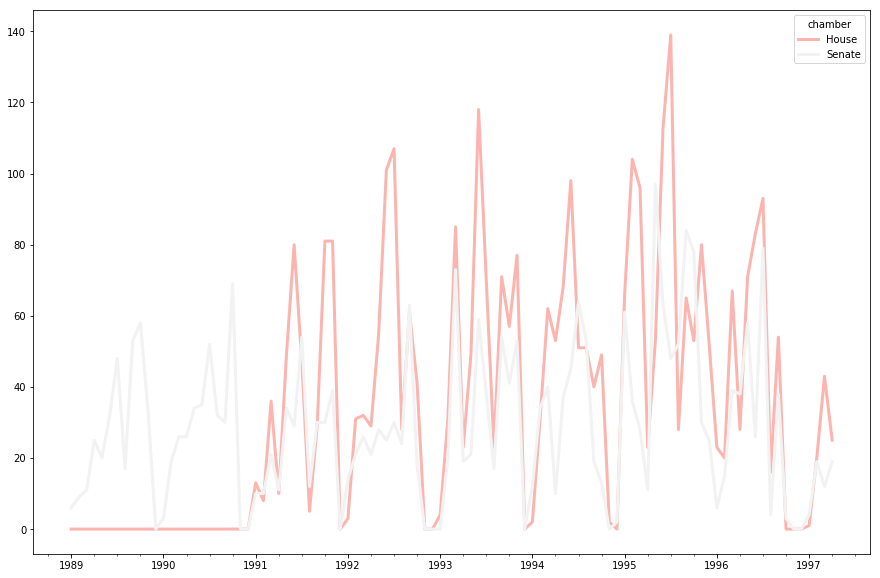

In [42]:
pvt = pd.DataFrame(vote_data).pivot_table(index='date',
                                    columns = 'chamber',
                                    aggfunc = 'count')['url']
pvt.index = pvt.index.to_datetime()
pvt = pvt.resample('m').sum().fillna(0)
pvt.head(100).plot(figsize=(15,10), lw=3,colormap='Pastel1')

In [43]:
# compare
congress.members.compare('S000033','C001098','senate',congress=congress_meeting)

{'agree_percent': 16.15,
 'chamber': 'Senate',
 'common_votes': 384,
 'congress': '115',
 'disagree_percent': 83.85,
 'disagree_votes': 322,
 'first_member_api_uri': 'https://api.propublica.org/congress/v1/members/S000033.json',
 'first_member_id': 'S000033',
 'second_member_api_uri': 'https://api.propublica.org/congress/v1/members/C001098.json',
 'second_member_id': 'C001098'}

In [44]:
# passed bills
pd.DataFrame(congress.bills.passed('senate')['bills']).tail(3)

,active,bill_id,bill_slug,bill_type,bill_uri,committee_codes,committees,congressdotgov_url,cosponsors,cosponsors_by_party,...,sponsor_name,sponsor_party,sponsor_state,sponsor_title,sponsor_uri,subcommittee_codes,summary,summary_short,title,vetoed
17,True,s2040-115,s2040,s,https://api.propublica.org/congress/v1/115/bil...,[SSGA],Senate Homeland Security and Governmental Affa...,https://www.congress.gov/bill/115th-congress/s...,1,{'R': 1},...,Pat Roberts,R,KS,Sen.,https://api.propublica.org/congress/v1/members...,[],Designates the facility of the United States P...,Designates the facility of the United States P...,A bill to designate the facility of the United...,None
18,True,s2030-115,s2030,s,https://api.propublica.org/congress/v1/115/bil...,"[HSIF, SSEG]",House Energy and Commerce Committee,https://www.congress.gov/bill/115th-congress/s...,3,"{'D': 2, 'R': 1}",...,Thom Tillis,R,NC,Sen.,https://api.propublica.org/congress/v1/members...,"[HSIF03, SSEG01]",Ceiling Fan Energy Conservation Harmonization ...,Ceiling Fan Energy Conservation Harmonization ...,A bill to deem the compliance date for amended...,None
19,True,hr3731-115,hr3731,hr,https://api.propublica.org/congress/v1/115/bil...,"[SSJU, HSGO, HSJU]",Senate Judiciary Committee,https://www.congress.gov/bill/115th-congress/h...,15,"{'D': 5, 'R': 10}",...,John Katko,R,NY,Rep.,https://api.propublica.org/congress/v1/members...,[HSJU08],Secret Service Recruitment and Retention Act o...,Secret Service Recruitment and Retention Act o...,To provide overtime pay for employees of the U...,None
